# Final Project

#### GROUP NUMBER 2
### MEMBERS:
#### Federico Marinozzi: 3136855
#### Leonardo Polverari: 3122388
#### Mattia Angius: 3130282


# DISCLAIMER

Because of the difficulties in obtaining convergence in the Metropolis Hastings algorithm, to retrieve coefficients as close as possible to the fisher ones, the algorithm was run with 500.000 iterations. Because of the high amount of time that took to run the simulation (around 30 minutes) that part of the code has been commented, leaving the output visible. 
For this reason we would suggest **NOT TO RUN ALL THE CELLS AT ONCE**, to avoid having to wait too much or losing the output.
We apologise for the inconvenience, but this was the only way we found to reach acceptable results. 

## Importing libraries

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, multivariate_normal
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

## Fisher Scoring Algorythm

A class structure was used to implement the fisher scoring method in order to be able to track convergence of the parameters and of the log-likelihood over the iterations

In [47]:
class probit():
    def __init__(self, X, y, epsilon = 0.0000001, n_iter = 1000, ignore_convergence = False):
            
            n,p = np.shape(X)

            beta_hist = []
            LL_hist = []

            b_0 = np.zeros((p,1))
            eta = np.dot(X,b_0)
            mu = norm.cdf(eta) 
            W = np.diag((1/(mu*(1-mu))*(norm.pdf(eta)**2)).reshape(n,))
            Z = eta + (y - mu)/(norm.pdf(eta))
            LL = np.sum(y * np.log(mu) + (1 - y) * np.log(1 - mu))

            convergence = False
            while not convergence:
                b = np.linalg.multi_dot([np.linalg.inv(np.linalg.multi_dot([X.T, W, X])), X.T,W, Z])
                eta = np.dot(X, b)
                mu = norm.cdf(eta) #mu
                W = np.diag((1/(mu*(1-mu))*(norm.pdf(eta)**2)).reshape(n,))
                Z = eta + (y - mu)/(norm.pdf(eta))
                LL = np.sum(y * np.log(mu) + (1 - y) * np.log(1 - mu))
                beta_hist.append(b_0.reshape(p, ))
                LL_hist.append(LL)
                
                if n_iter == 0:
                     convergence = True
                if np.linalg.norm(b-b_0)/(np.linalg.norm(b_0)+epsilon) < epsilon:
                
                    if ignore_convergence == False:
                        convergence = True
                        print("\nConvergence reached with value:",np.linalg.norm(b-b_0)/(np.linalg.norm(b_0)+epsilon))
                b_0 = b 
                
                n_iter -= 1
            
            self.coefficients = b
            self.log_likelihood = LL
            self.beta_history = pd.DataFrame(beta_hist, columns = ['beta' + str(i) for i in range(p)])
            self.LL_history = pd.DataFrame({'Log-Likelihood' : LL_hist})
            


### Fitting the data

In [120]:
df = pd.read_csv('SAheart.txt', sep=" ")
df.loc[df['famhist'] == 'Present', 'famhist'] = 1
df.loc[df['famhist'] == 'Absent', 'famhist'] = 0
df['famhist'] = df['famhist'].astype(int)
# df.head()
# df.info()

In [121]:
X = np.array(df.drop(['chd'], axis=1))
n, p = np.shape(X)
X = np.hstack((X, np.ones((n, 1)))) 
y = np.array(df['chd']).reshape((n, 1))

In [122]:
mod = probit(X, y)


Convergence reached with value: 7.091248360054871e-08


#### Coefficients

In [123]:
mod.coefficients

array([[ 3.78935601e-03],
       [ 4.82198099e-02],
       [ 1.02828863e-01],
       [ 1.23956593e-02],
       [ 5.38979000e-01],
       [ 2.35557473e-02],
       [-4.01620824e-02],
       [ 1.95572378e-05],
       [ 2.62694088e-02],
       [-3.57018428e+00]])

### Convergence diagnostics

#### Beta convergence

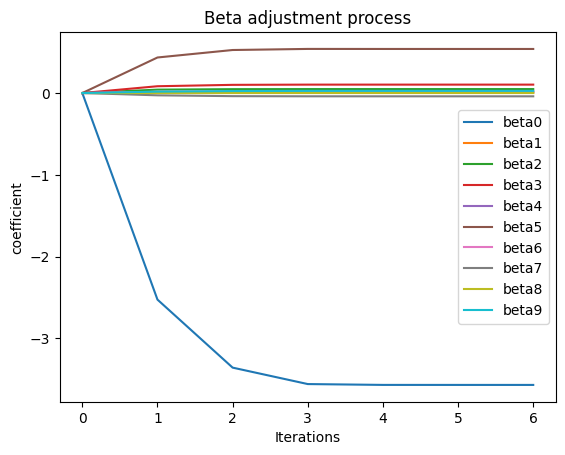

In [53]:
mod.beta_history.plot()
plt.title('Beta adjustment process')
plt.xlabel('Iterations')
plt.ylabel('coefficient')
plt.show()

#### Log-Likelihood convergence

In [54]:
print(mod.log_likelihood)

-235.96203934155494


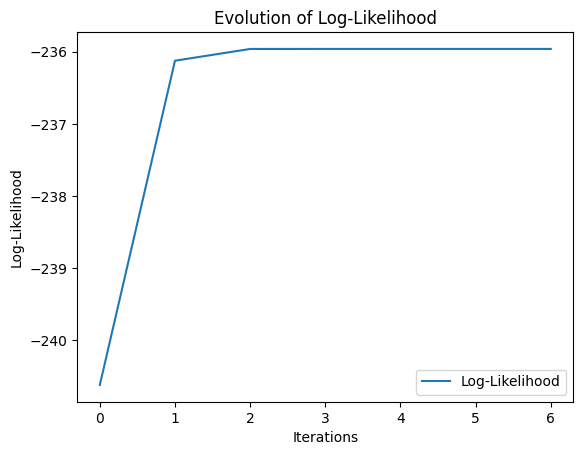

In [9]:
mod.LL_history.plot()
plt.title('Evolution of Log-Likelihood')
plt.xlabel('Iterations')
plt.ylabel('Log-Likelihood')
plt.show()

## Random Walk Metropolis-Hastings

In [155]:
def probit_likelihood(b_0, X, y):
    eta = np.dot(X,b_0)
    mu = norm.cdf(eta) 
    l = np.prod(mu ** y * (1 - mu) ** (1 - y))
    return l

In [156]:
def prior_normal(b_0):
    prior = np.prod(norm.pdf(b_0))
    return prior

def prior_uninformative(b_0):
    return 1

In [157]:
def metropolis_hastings(X, y, n_iter=10000, t=0.1, prior = prior_normal):
    """
    Implement Metropolis-Hastings algorithm for Bayesian Probit Regression.
    """
    n, p = np.shape(X)
    b_0 = np.zeros(p)
    samples = []
    accepted = 0
    for i in range(n_iter):
        
        proposal = b_0 + np.random.normal(0, t, size=b_0.shape)
        ratio = min(1, (probit_likelihood(proposal, X, y) * prior(proposal)) / (probit_likelihood(b_0, X, y) * prior(b_0)))

        if np.random.rand() < ratio:
            b_0 = proposal
            accepted += 1
        samples.append(b_0.reshape((X.shape[1], )))

    
    print(f'acceptance rate = {accepted/n_iter}')
    return pd.DataFrame(samples, columns = ['beta' + str(i) for i in range(X.shape[1])])

### Simulated data

Since with multiple trials on the SAheart dataset the chain did not mix perfectly, we tried our algorithm on simulated data

In [58]:
import numpy as np
from scipy.stats import norm

np.random.seed(0)


n = 1000
p = 5

X_sim = np.random.normal(0, 1, size=(n, p))

b_true = np.array([0.5, -0.2, 0.3, 0.4, -0.5])

eta = np.dot(X_sim, b_true)
mu = norm.cdf(eta)
y_sim = np.random.binomial(1, mu)

In [59]:
sim = metropolis_hastings(X_sim, y_sim, n_iter = 10000, t = 0.02)

acceptance rate = 0.653


<AxesSubplot: >

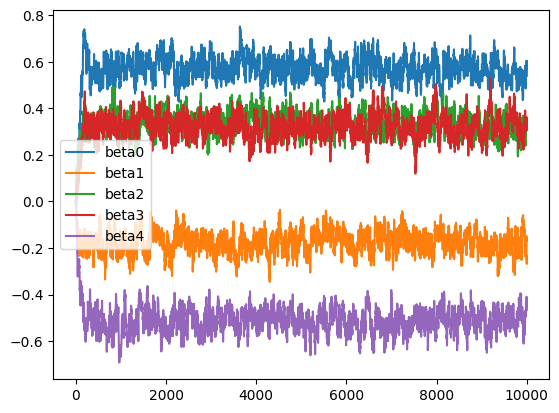

In [60]:
sim.plot()

<AxesSubplot: >

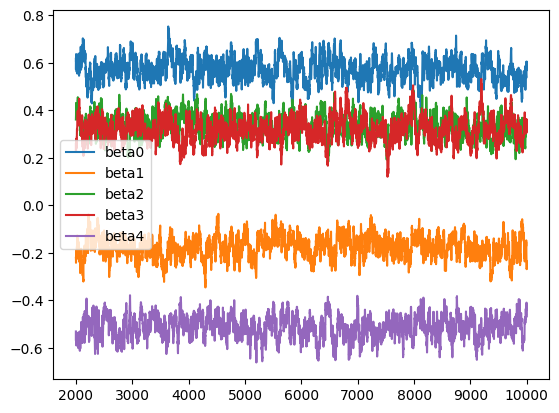

In [61]:
# burnin:
sim = sim.loc[2000:, :]
sim.plot()

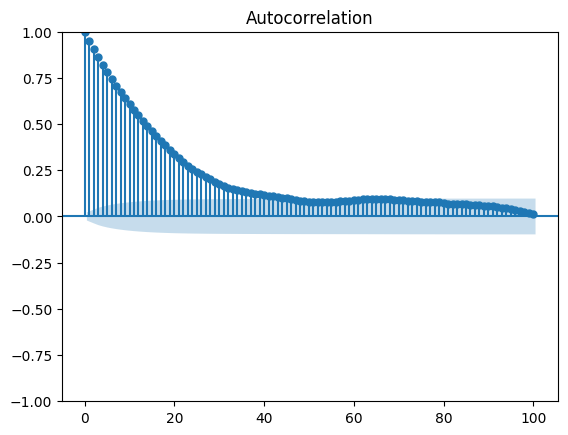

In [62]:
plot_acf(sim['beta0'], lags = 100)
plt.show()

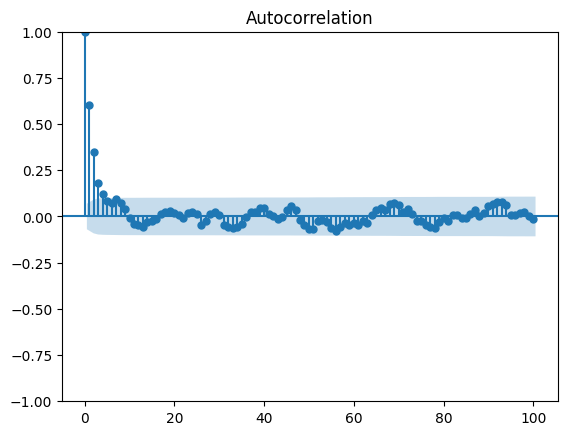

In [63]:
# thinning:
sim = sim[::10]
plot_acf(sim['beta0'], lags = 100)
plt.show()

<AxesSubplot: >

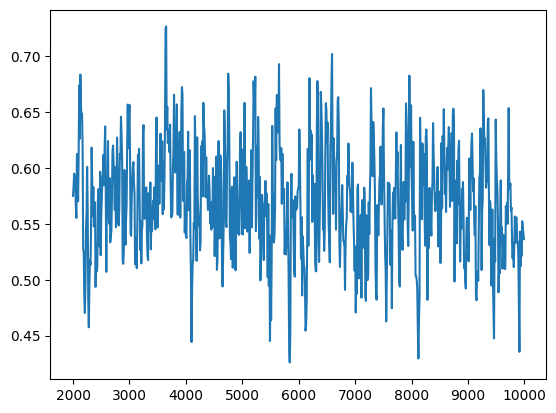

In [66]:
sim['beta0'].plot()

In [65]:
estimated_betas = sim.mean()
estimated_betas

beta0    0.570693
beta1   -0.176036
beta2    0.335638
beta3    0.319100
beta4   -0.511433
dtype: float64

The results are not bad!

## Scaled Data

For the same reason as above, we tride our algorithm on scaled data, with good results (better than the ones on unscaled data). However, because of the scaling, the obtained coefficients are not suitable for interpretation

In [114]:
df = pd.read_csv('SAheart.txt', sep=" ")
df.loc[df['famhist'] == 'Present', 'famhist'] = 1
df.loc[df['famhist'] == 'Absent', 'famhist'] = 0
df['famhist'] = df['famhist'].astype(int)
df['const'] = 1
# df.head()

In [115]:
scaler = StandardScaler()
df_X = df.drop('chd', axis = 1)
df_X.loc[:, df_X.columns != 'famhist'] = scaler.fit_transform(df_X.loc[:, df_X.columns != 'famhist'])
df_y = df['chd']

C:\Users\lepol\AppData\Local\Temp\ipykernel_11636\1222785862.py:3: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_X.loc[:, df_X.columns != 'famhist'] = scaler.fit_transform(df_X.loc[:, df_X.columns != 'famhist'])


In [116]:
df_X['const'] = 1

In [100]:
np.random.seed(123)
SAheart = metropolis_hastings(df_X, df_y, t=0.03, n_iter=20000)

acceptance rate = 0.518


Text(0, 0.5, 'coefficient')

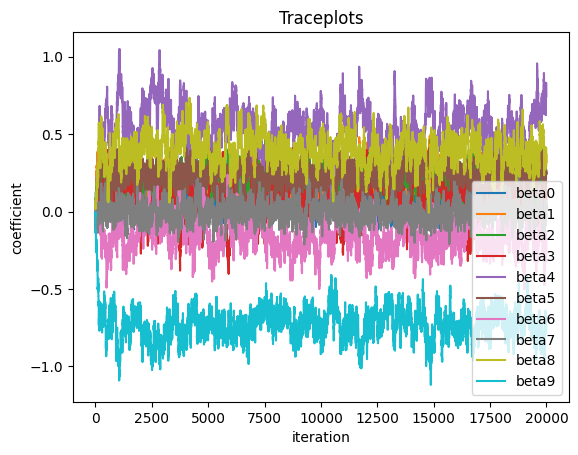

In [101]:
SAheart.plot()
plt.title('Traceplots')
plt.xlabel('iteration')
plt.ylabel('coefficient')

In [102]:
# burn in:
SAheart = SAheart.loc[7500:, :]

Text(0, 0.5, 'coefficient')

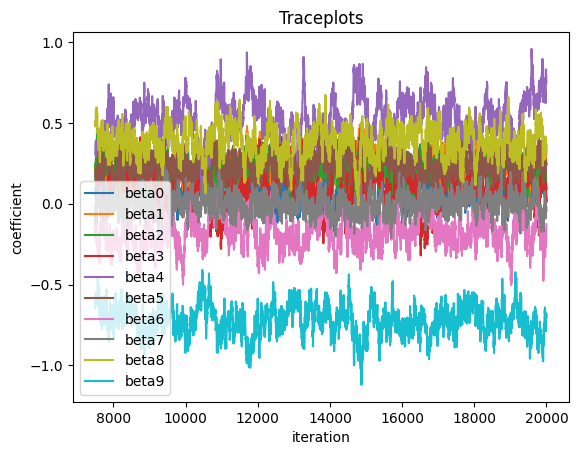

In [103]:
SAheart.plot()
plt.title('Traceplots')
plt.xlabel('iteration')
plt.ylabel('coefficient')

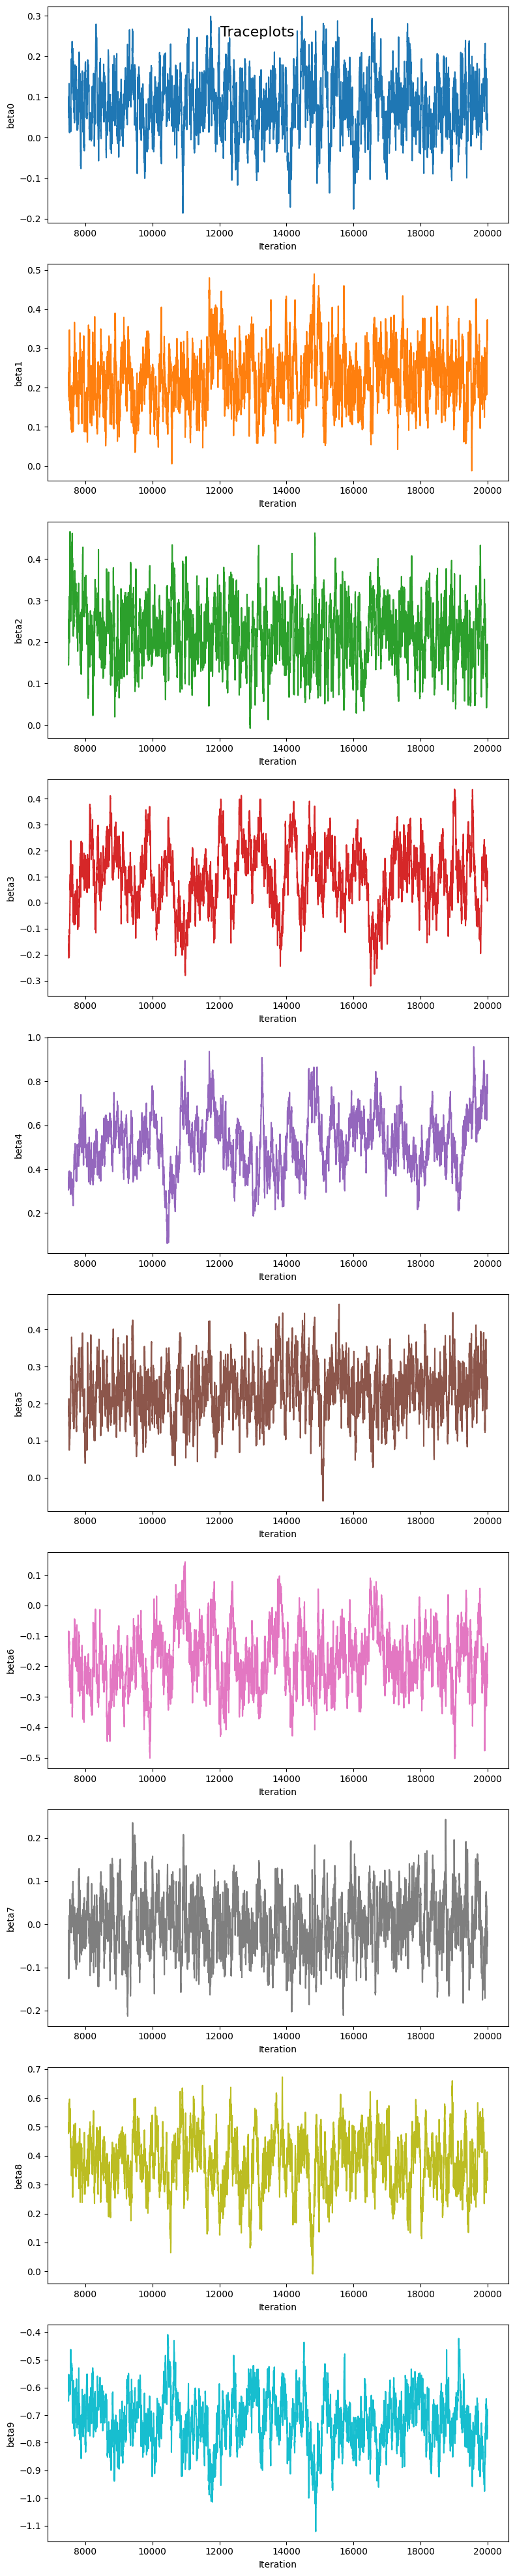

In [104]:
fig, axs = plt.subplots(len(SAheart.columns), 1, figsize=(8, len(SAheart.columns)*4))

# Add general title above the first graph
fig.suptitle('Traceplots', fontsize=16)

for i, col in enumerate(SAheart.columns):
    axs[i].plot(SAheart[col], color='C'+str(i))
    axs[i].set_ylabel(col)
    axs[i].set_xlabel('Iteration')

plt.tight_layout()
plt.show()


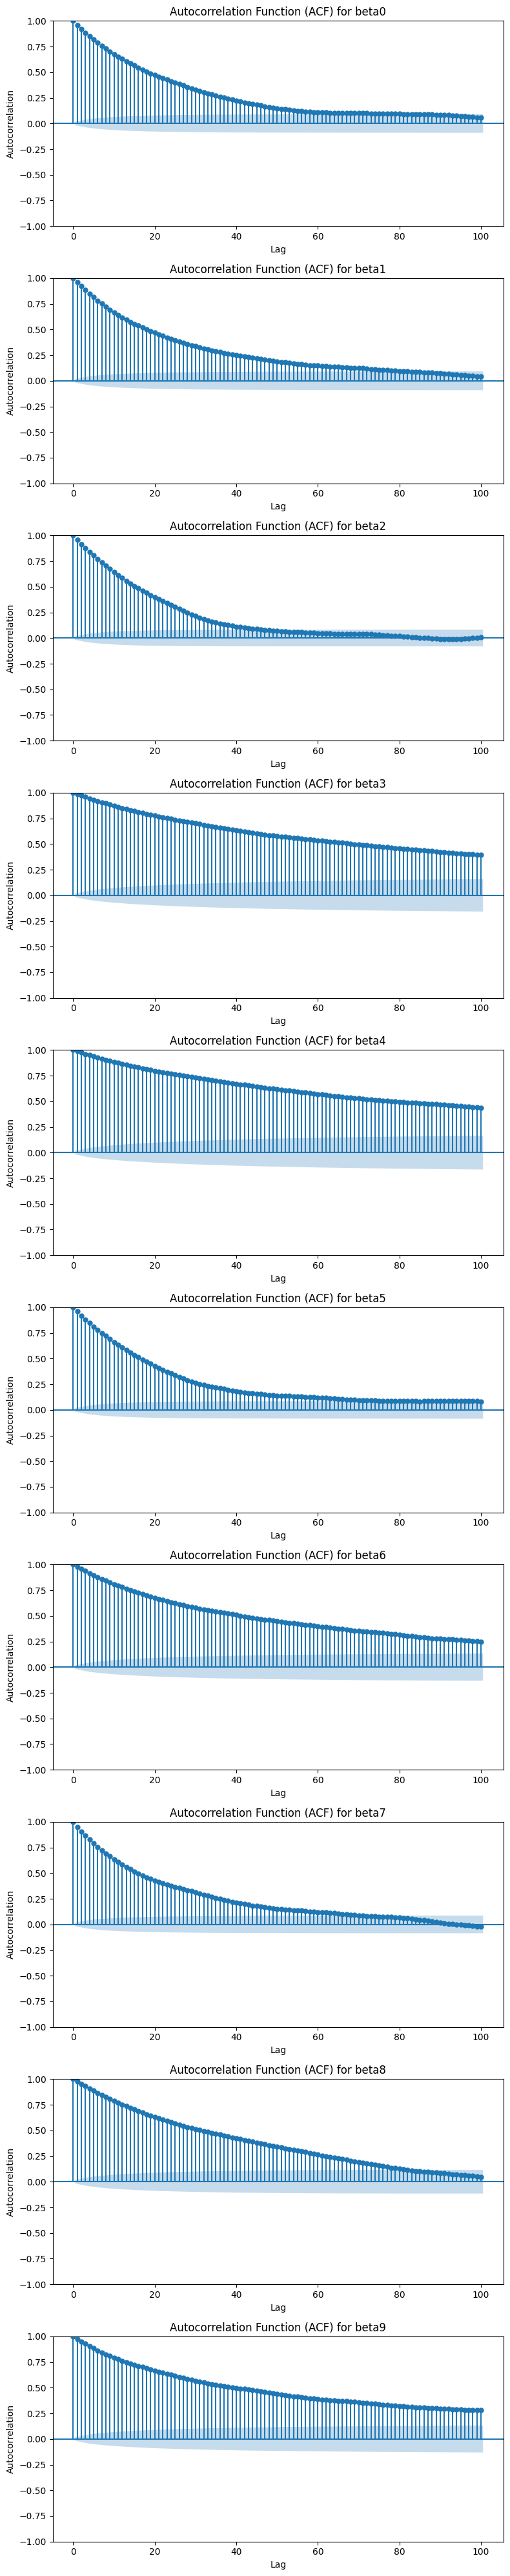

In [105]:
fig, axs = plt.subplots(len(SAheart.columns), 1, figsize=(8, len(SAheart.columns)*4))

for i, col in enumerate(SAheart.columns):
    ax = axs[i]
    plot_acf(SAheart[col], lags=100, ax=ax)
    ax.set_xlabel('Lag')
    ax.set_ylabel('Autocorrelation')
    ax.set_title(f'Autocorrelation Function (ACF) for {col}')

plt.tight_layout()
plt.show()


### thinning

In [106]:
SAheart = SAheart[::10]

In [108]:
SAheart = SAheart[::10]

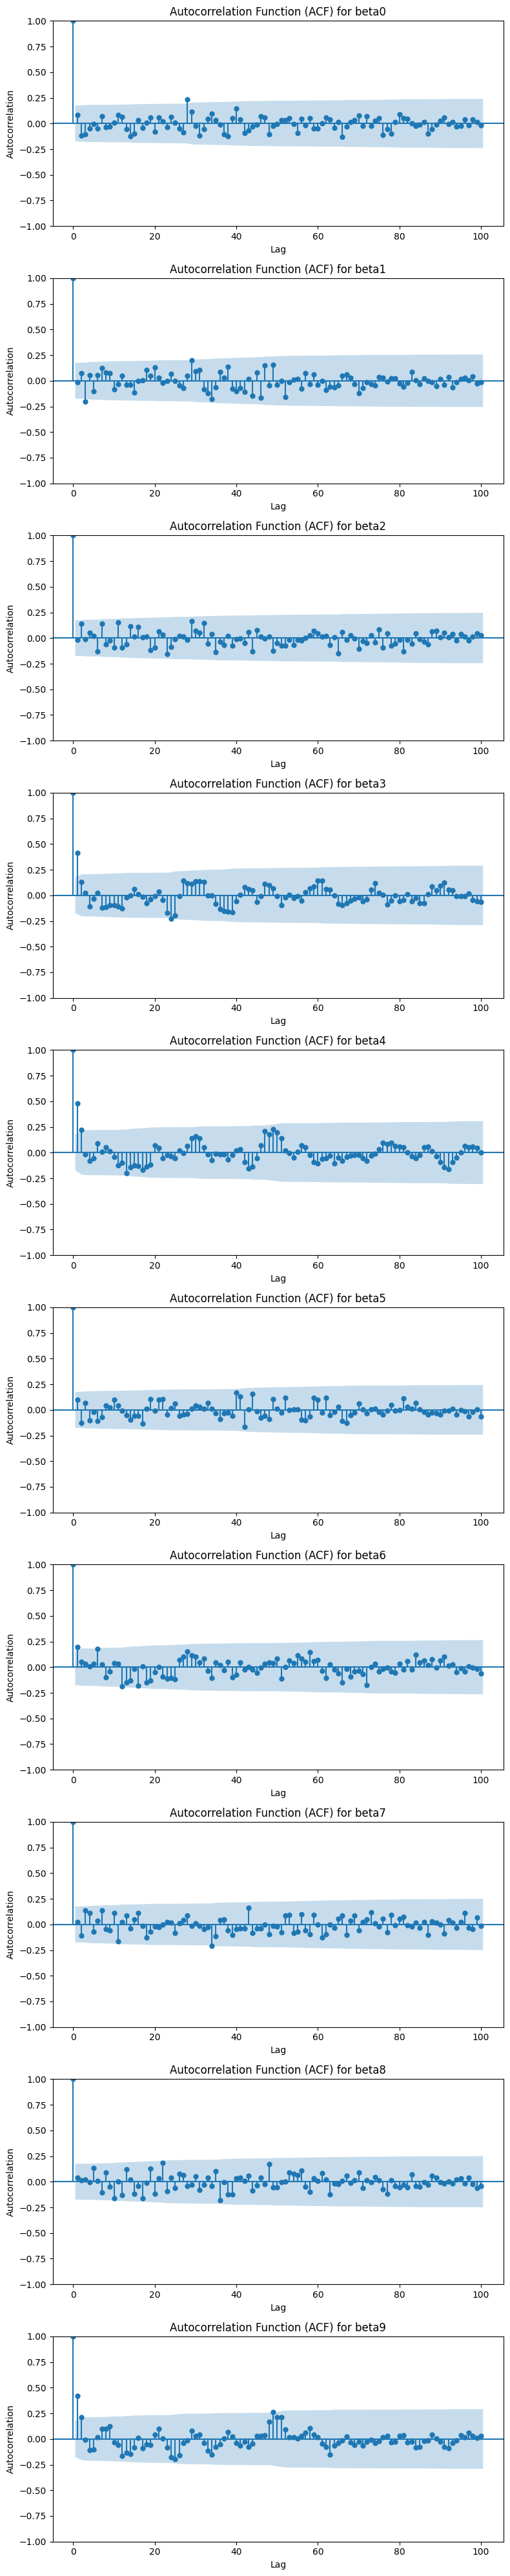

In [109]:
fig, axs = plt.subplots(len(SAheart.columns), 1, figsize=(8, len(SAheart.columns)*4))

for i, col in enumerate(SAheart.columns):
    ax = axs[i]
    plot_acf(SAheart[col], lags=100, ax=ax)
    ax.set_xlabel('Lag')
    ax.set_ylabel('Autocorrelation')
    ax.set_title(f'Autocorrelation Function (ACF) for {col}')

plt.tight_layout()
plt.show()

### estimation

In [110]:
SAheart.mean()

beta0    0.083809
beta1    0.229977
beta2    0.220417
beta3    0.100911
beta4    0.528041
beta5    0.228982
beta6   -0.176646
beta7    0.002930
beta8    0.374642
beta9   -0.722943
dtype: float64

## Unscaled Data

In [141]:
df = pd.read_csv('SAheart.txt', sep=" ")
df.loc[df['famhist'] == 'Present', 'famhist'] = 1
df.loc[df['famhist'] == 'Absent', 'famhist'] = 0
df['famhist'] = df['famhist'].astype(int)
df['const'] = 1
df.head()

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd,const
0,160,12.00,5.73,23.11,1,49,25.30,97.20,52,1,1
1,144,0.01,4.41,28.61,0,55,28.87,2.06,63,1,1
2,118,0.08,3.48,32.28,1,52,29.14,3.81,46,0,1
3,170,7.50,6.41,38.03,1,51,31.99,24.26,58,1,1
4,134,13.60,3.50,27.78,1,60,25.99,57.34,49,1,1


In [144]:
np.random.seed(123)
# SAheart = metropolis_hastings(df.drop('chd', axis = 1), df['chd'], t=0.0006, n_iter=500000)

acceptance rate = 0.566908


Text(0, 0.5, 'coefficient')

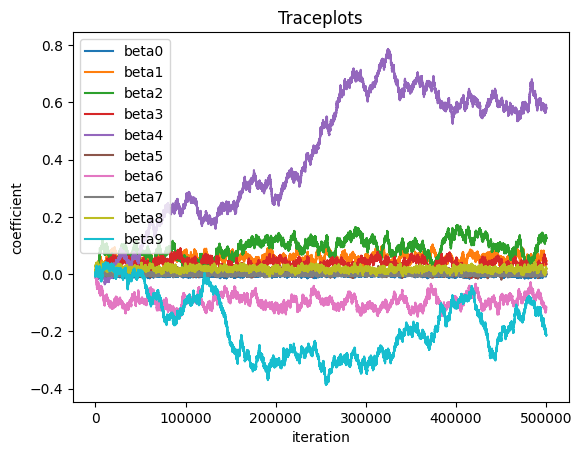

In [145]:
# SAheart.plot()
# plt.title('Traceplots')
# plt.xlabel('iteration')
# plt.ylabel('coefficient')

In [146]:
# burn in:
# SAheart = SAheart.loc[350000:, :]

Text(0, 0.5, 'coefficient')

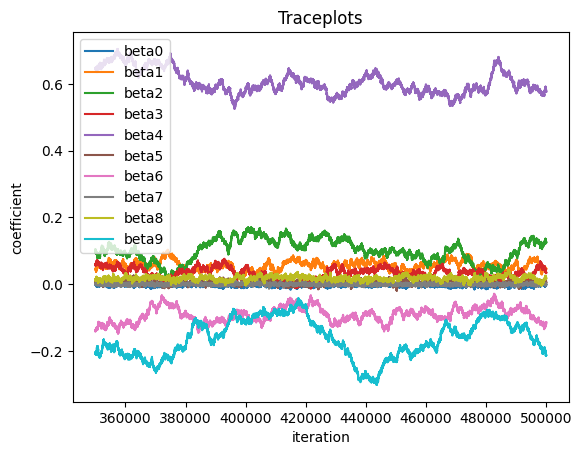

In [147]:
# SAheart.plot()
# plt.title('Traceplots')
# plt.xlabel('iteration')
# plt.ylabel('coefficient')

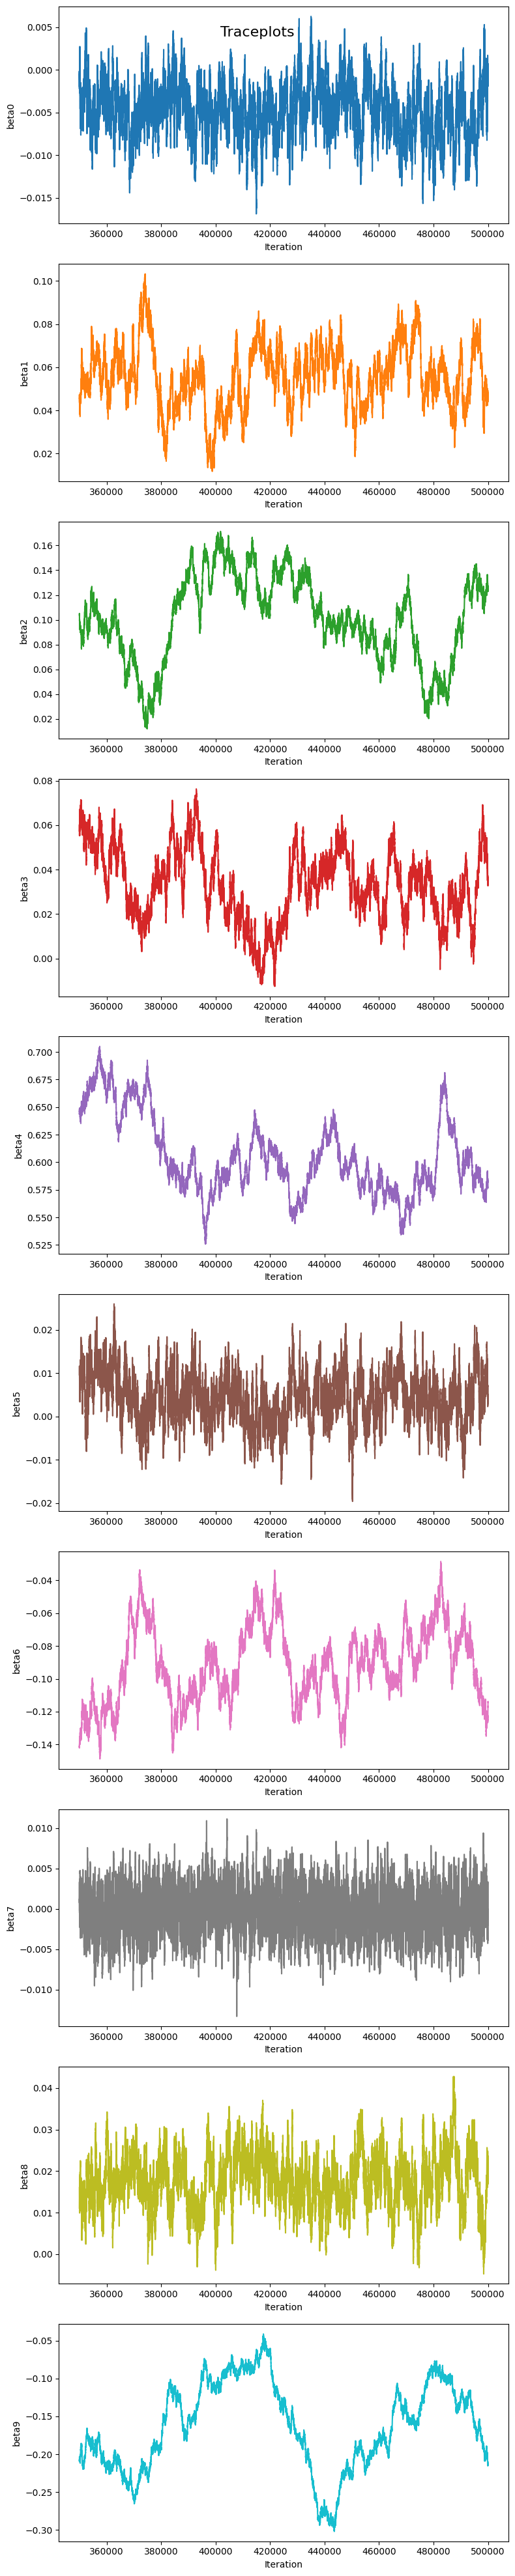

In [148]:
# fig, axs = plt.subplots(len(SAheart.columns), 1, figsize=(8, len(SAheart.columns)*4))

# # Add general title above the first graph
# fig.suptitle('Traceplots', fontsize=16)

# for i, col in enumerate(SAheart.columns):
#     axs[i].plot(SAheart[col], color='C'+str(i))
#     axs[i].set_ylabel(col)
#     axs[i].set_xlabel('Iteration')

# plt.tight_layout()
# plt.show()




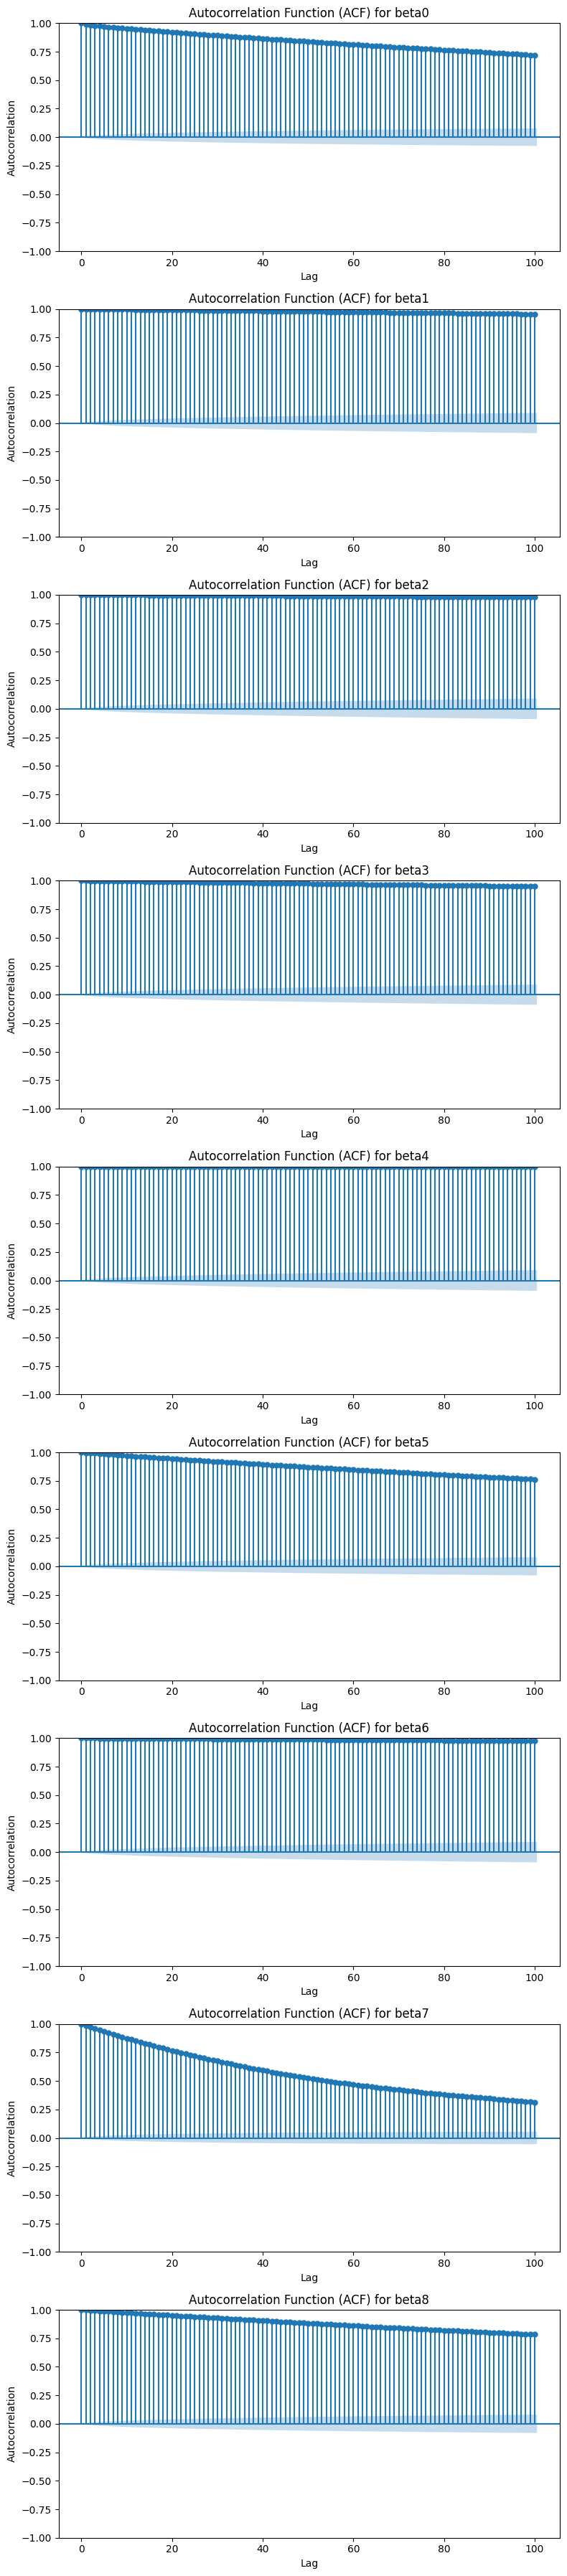

In [133]:
# fig, axs = plt.subplots(len(SAheart.columns), 1, figsize=(8, len(SAheart.columns)*4))

# for i, col in enumerate(SAheart.columns):
#     ax = axs[i]
#     plot_acf(SAheart[col], lags=100, ax=ax)
#     ax.set_xlabel('Lag')
#     ax.set_ylabel('Autocorrelation')
#     ax.set_title(f'Autocorrelation Function (ACF) for {col}')

# plt.tight_layout()
# plt.show()


### thinning

In [149]:
# SAheart = SAheart[::10]

In [150]:
# SAheart = SAheart[::10]

In [151]:
# SAheart = SAheart[::10]

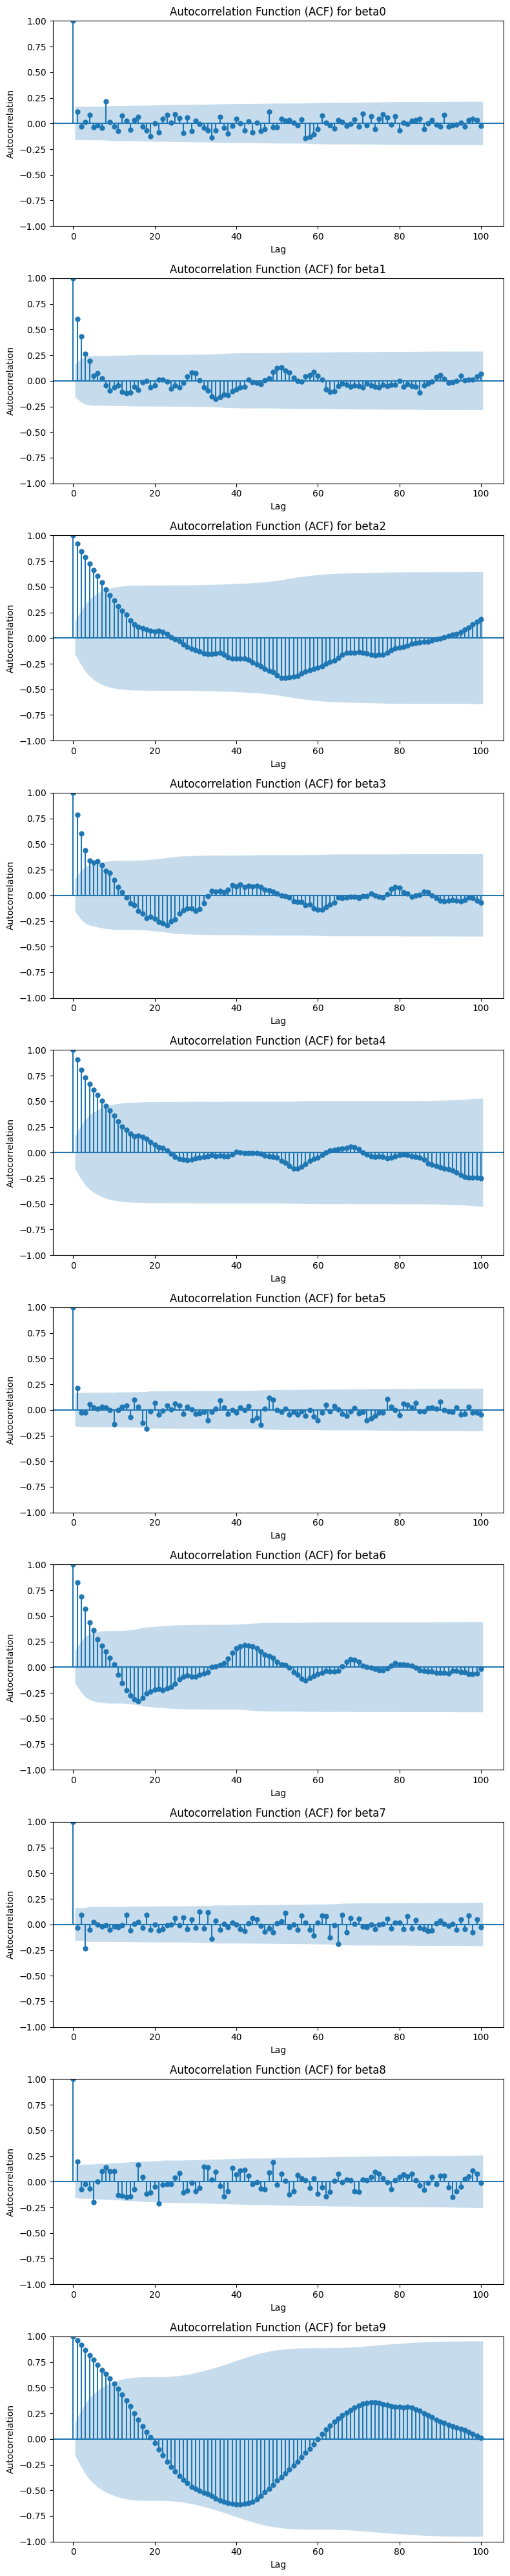

In [152]:
# fig, axs = plt.subplots(len(SAheart.columns), 1, figsize=(8, len(SAheart.columns)*4))

# for i, col in enumerate(SAheart.columns):
#     ax = axs[i]
#     plot_acf(SAheart[col], lags=100, ax=ax)
#     ax.set_xlabel('Lag')
#     ax.set_ylabel('Autocorrelation')
#     ax.set_title(f'Autocorrelation Function (ACF) for {col}')

# plt.tight_layout()
# plt.show()

### estimation

In [168]:
# SAheart = SAheart.rename(columns={'beta0' : 'sbp', 'beta1' : 'tobacco', 'beta2' : 'ldl', 'beta3' : 'adiposity', 'beta4' : 'famhist', 'beta5' : 'typea',
#                         'beta6' : 'obesity', 'beta7' : 'alcohol', 'beta8' : 'age', 'beta9' : 'const'})

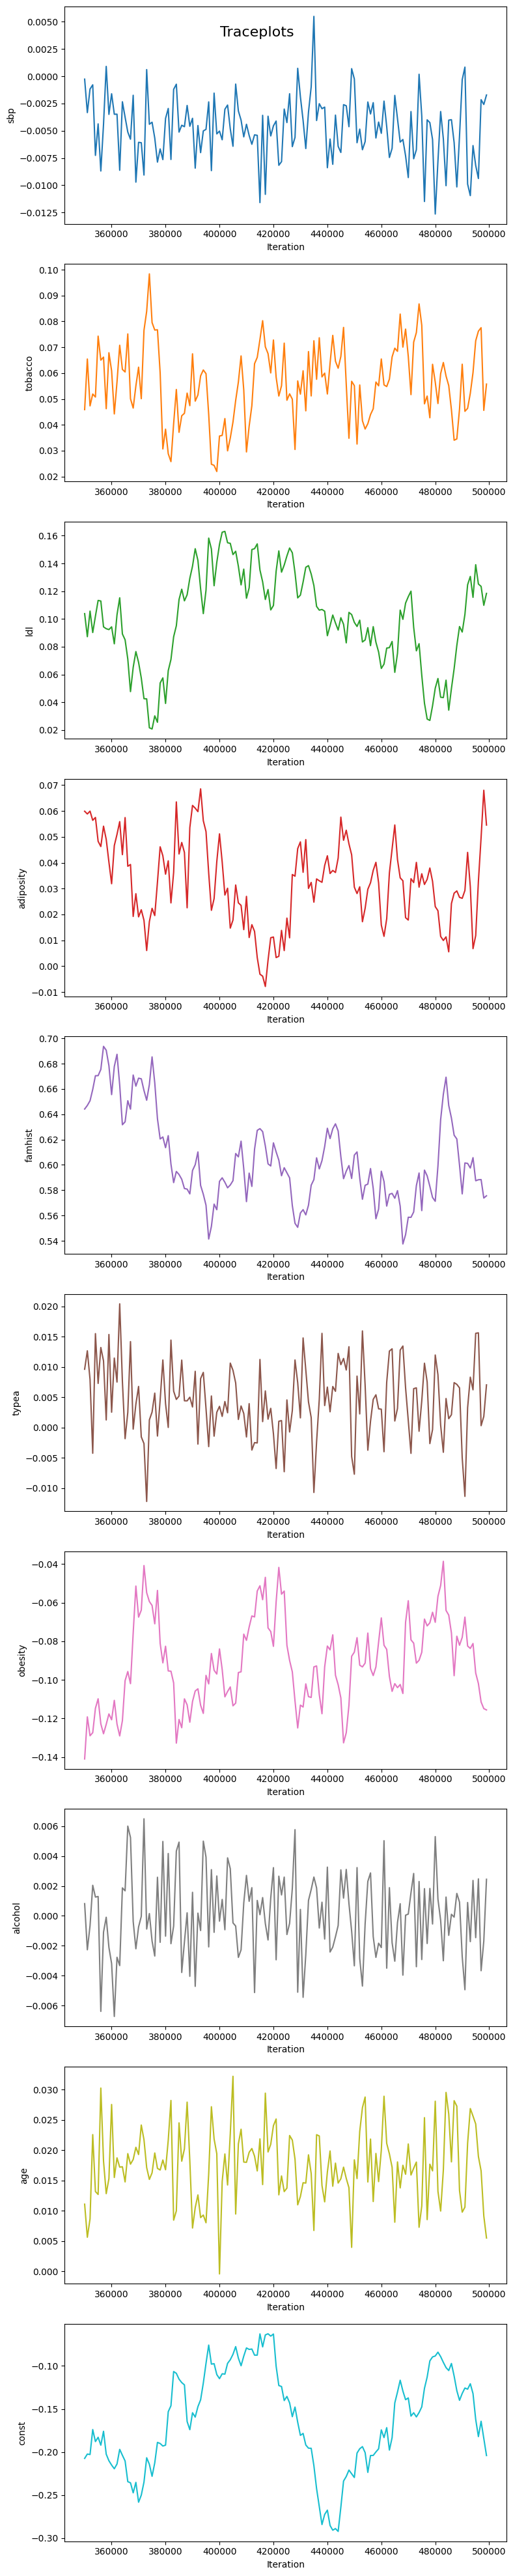

In [171]:
# fig, axs = plt.subplots(len(SAheart.columns), 1, figsize=(8, len(SAheart.columns)*4))

# # Add general title above the first graph
# fig.suptitle('Traceplots', fontsize=16)

# for i, col in enumerate(SAheart.columns):
#     axs[i].plot(SAheart[col], color='C'+str(i))
#     axs[i].set_ylabel(col)
#     axs[i].set_xlabel('Iteration')

# plt.tight_layout()
# plt.show()

In [169]:
# SAheart.mean()

sbp         -0.004764
tobacco      0.055984
ldl          0.099981
adiposity    0.032616
famhist      0.605451
typea        0.004535
obesity     -0.091423
alcohol     -0.000004
age          0.017505
const       -0.161962
dtype: float64

From the traceplots it is clear that, despite the acceptance rate is quite good, the chain does not mix well for most of the parameters